In [1]:
import cufflinks as cf
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from ta import add_all_ta_features
from ta.utils import dropna
from _lumber_prices import get_lumber_db_xl

# FETCH Data

In [2]:
def add_technical_indicators(TA_df):

    TA_df.columns = ['Open','High','Low','Close','Volume','OpenInterest']
    TA_df = dropna(TA_df)
    TA_df.sort_index(ascending=True, inplace=True)
    TA_df = add_all_ta_features(TA_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
    TA_df.sort_index(ascending=False, inplace=True)
    TA_df.drop(['Open','High','Low','Close','Volume','OpenInterest'],axis=1,inplace=True)
    TA_df.columns = [('TA_',x) for x in TA_df.columns]
    TA_df = TA_df.replace([np.inf, -np.inf], np.nan).fillna(TA_df.mean())
    return TA_df

# This func combines all trading dates from Barchart (historical) and cwp live lumber trading dates
def lumber_trading_days():
    barchart_idx = pd.DatetimeIndex(pd.DataFrame(pd.read_csv('F:/Traders/2x4/Adjusted CME Futures/Switch_OI/Lumber.csv',index_col=0)).index)
    cwp_idx = get_lumber_db_xl()[1].index
    cwp_idx = cwp_idx[cwp_idx>barchart_idx[0]]
    return cwp_idx.append(barchart_idx).sort_values(ascending=False)


# 
file_path = 'C:/source/2x4-data/app/model_building/daily_dataframe_main.xlsx'
### Reading Data from Excel daily_dataframe_main - Takes 1 min 40 secs to run
Variables = pd.read_excel(file_path, header=[0,1], sheet_name='Variables',index_col=0)
Response = pd.read_excel(file_path,sheet_name= 'Response' ,index_col=0)
TA_df = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
TA_df = add_technical_indicators(TA_df)
TA_df.replace([np.inf, -np.inf], np.nan, inplace=True)
TA_df.fillna(method='bfill', inplace=True)

Variables.sort_index(ascending = False, inplace = True)
Response.sort_index(ascending = False, inplace = True)

cme = mcal.get_calendar("CME_Agriculture")
cme_trading_days = cme.schedule(start_date=Variables.index[-1].date(), end_date=Variables.index[0].date()).index
cme_trading_days = cme_trading_days.sort_values(ascending=False)
cme_trading_days = pd.DatetimeIndex(cme_trading_days)

trading_days = lumber_trading_days()
# Variables = Variables[Variables.index > '2012-01-01']
Variables = Variables[Variables.index.isin(cme_trading_days)]
Variables = Variables[Variables.index.isin(trading_days)]

# Response = Response[Response.index > '2012-01-01']
Response = Response[Response.index.isin(cme_trading_days)]
Response = Response[Response.index.isin(trading_days)]
# Response = Response[(Response.Close_Up_Down == 1) | (Response.Close_Up_Down == -1)]

Variables.index = pd.DatetimeIndex(Variables.index)
Response.index = pd.DatetimeIndex(Response.index)
Variables = Variables.reindex(Response.index)

Variables.drop(Variables.columns[Variables.isna().all()].to_list(), axis=1, inplace=True)
Variables.drop(Variables.columns[Variables.isnull().all()].to_list(), axis=1, inplace=True)

Response.drop(Response.columns[Response.isna().all()].to_list(), axis=1, inplace=True)
Response.drop(Response.columns[Response.isnull().all()].to_list(), axis=1, inplace=True)

Getting data from CWP database & excel files::  33%|███▎      | 1/3 [00:04<00:08,  4.23s/it]

Time Taken for Contract:1 00:04


Getting data from CWP database & excel files::  67%|██████▋   | 2/3 [00:07<00:03,  3.48s/it]

Time Taken for Contract:2 00:07


Getting data from CWP database & excel files:: 100%|██████████| 3/3 [00:10<00:00,  3.38s/it]

Time Taken for Contract:3 00:10


In [191]:
Lumber_OHLCVI = Variables.loc[:,('Lumber_Adjusted_dfs',)][['Adj_open3','Adj_high3','Adj_low3','Adj_close3','volume3','openInterest3']]
Lumber_OHLCVI.columns = ['Open','High','Low','Close','Volume','OpenInterest']
Lumber_OHLCVI = Lumber_OHLCVI.shift(1)
Lumber_OHLCVI.dropna(inplace=True)
Lumber_OHLCVI

,Open,High,Low,Close,Volume,OpenInterest
2022-08-12,595.599976,611.400024,583.799988,588.700012,219.0,1569.0
2022-08-11,601.799988,635.599976,577.099976,595.599976,647.0,1654.0
2022-08-10,552.799988,601.799988,573.000000,601.799988,487.0,1808.0
2022-08-09,519.299988,565.000000,528.400024,552.799988,376.0,1895.0
2022-08-08,479.200012,528.200012,483.200012,519.299988,398.0,1946.0
...,...,...,...,...,...,...
2011-01-12,190.001745,205.117027,198.089747,200.807846,291.0,6956.0
2011-01-11,192.719844,206.045158,200.741550,200.741550,477.0,6964.0
2011-01-10,202.200043,214.862406,207.371060,207.371060,1035.0,6857.0
2011-01-07,204.188895,220.696374,212.807258,214.000570,737.0,7268.0


In [192]:
cf.set_config_file(offline=True)

In [193]:
Lumber_OHLCVI.Close.iplot()

In [320]:
qf = cf.QuantFig(df = Lumber_OHLCVI.sort_index(ascending=True).iloc[:,:-1].loc["2021":"2022"])
qf.add_trendline(date0='2022-07-14', date1='2022-08-12')
qf.iplot()

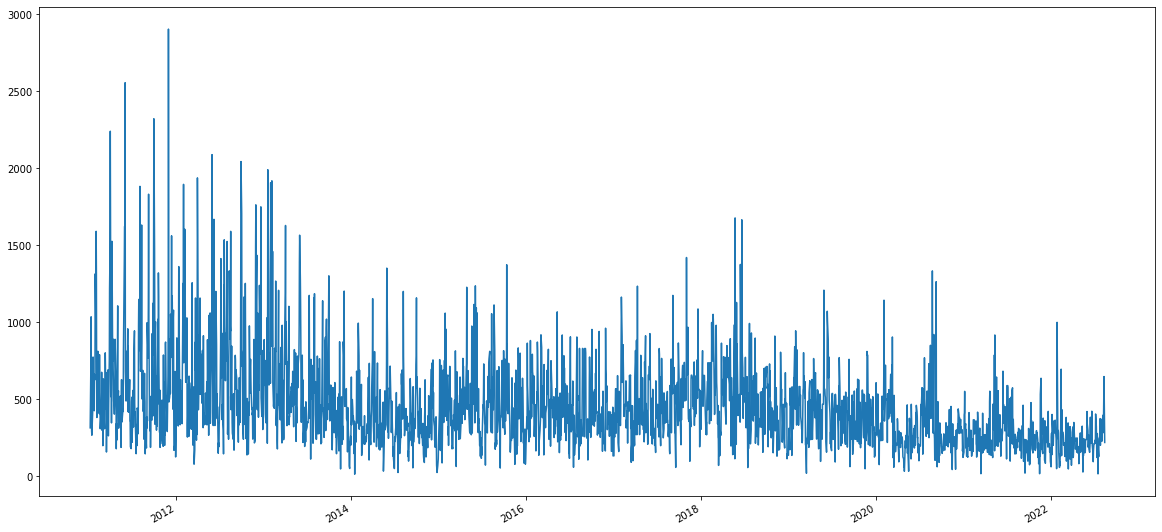

In [ ]:
Lumber_OHLCVI.Volume.plot(figsize=(20,10));

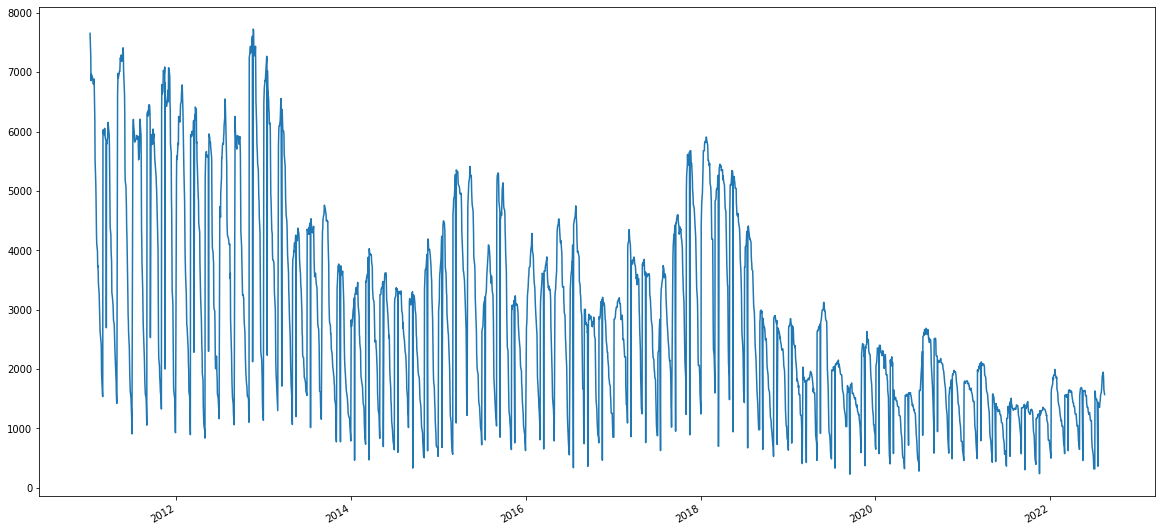

In [ ]:
Lumber_OHLCVI.OpenInterest.plot(figsize=(20,10));

In [ ]:
Lumber_OHLCVI.sort_index(ascending=True, inplace=True)
Lumber_OHLCVI.head()

,Open,High,Low,Close,Volume,OpenInterest
1969-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1969-10-02,NaN,4097.117236,3982.244790,4084.353631,NaN,NaN
1969-10-03,4084.353631,4109.880841,4058.826421,4109.880841,NaN,NaN
1969-10-06,4109.880841,4084.353631,4084.353631,4084.353631,NaN,NaN
1969-10-07,4084.353631,4109.880841,4084.353631,4084.353631,NaN,NaN


In [ ]:
returns = np.log(Lumber_OHLCVI.Close.div(Lumber_OHLCVI.Close.shift(1))).to_frame()
returns.columns = ['Returns']
returns = pd.concat([returns, Lumber_OHLCVI.Close], axis=1)
returns.dropna(inplace=True)
returns.describe()

,Returns,Close
count,13320.000000,13320.000000
mean,-0.000145,2513.643668
std,0.018292,2715.790823
min,-0.095972,98.326107
25%,-0.011504,538.192353
50%,0.000000,1683.576850
75%,0.010933,3126.754072
max,0.113713,13639.224988


In [ ]:
returns = returns[returns.index > "2010"] 
returns.Returns[0] = 0  # 0 return for first day
returns['creturns'] = returns.Returns.cumsum().apply(np.exp) # Shows $1 investment at start

In [ ]:
# bins = np.floor(np.sqrt(len(returns))).astype(int)
bins = 115
returns.Returns.iplot(kind='histogram', bins=bins)

In [195]:
returns.Returns.sum(), np.exp(returns.Returns.sum()) # np.exp to calculate investment value of 1 dollar

(1.0199224850812159, 2.7729798083286386)

In [196]:
returns.Close[-1]/returns.Close[0]

2.7729798083286448

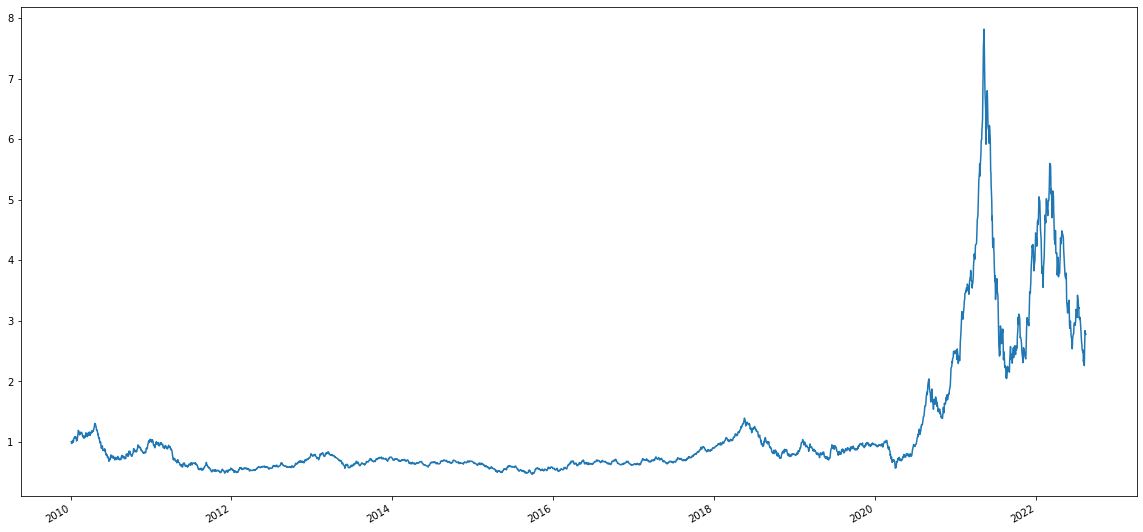

In [197]:
returns.creturns.plot(figsize=(20,10));

In [198]:
returns.describe()

,Returns,Close,creturns,cummax
count,3179.000000,3179.000000,3179.000000,3179.000000
mean,0.000321,245.527253,1.156518,2.067276
std,0.022240,232.840669,1.096760,1.989375
min,-0.095972,98.326107,0.463150,1.000000
25%,-0.012532,134.803747,0.634972,1.300100
50%,0.000000,155.227298,0.731174,1.300100
75%,0.013466,208.216700,0.980772,1.390000
max,0.103763,1659.354783,7.816133,7.816133


In [331]:
returns

,Returns,Close,creturns,cummax
2010-01-04,0.000000,212.298701,1.000000,1.000000
2010-01-05,-0.019705,208.156288,0.980488,1.000000
2010-01-06,-0.010467,205.988934,0.970279,1.000000
2010-01-07,0.035318,213.394060,1.005160,1.005160
2010-01-08,-0.018365,209.510884,0.986868,1.005160
...,...,...,...,...
2022-08-09,0.080364,519.299988,2.446082,7.816133
2022-08-10,0.062515,552.799988,2.603878,7.816133
2022-08-11,0.084929,601.799988,2.834685,7.816133
2022-08-12,-0.010356,595.599976,2.805481,7.816133


In [199]:
# Annualized returns and volatility
returns.Returns.mean() * 252, returns.Returns.std() * np.sqrt(252)

(0.08084947034931311, 0.35305384332767936)

### Annualized/Monthly return & volatily by year

In [200]:
annualized = returns.Returns.groupby(pd.Grouper(freq='A')).aggregate(['mean', 'std'])
annualized['mean'] = annualized['mean'] * 252
annualized['std'] = annualized['std'] * np.sqrt(252)
annualized.iplot(title='Annualized Returns & Volatility', yTitle='Returns',kind='bar')

In [201]:
annualized = returns.Returns.groupby(pd.Grouper(freq='M')).aggregate(['mean', 'std'])
annualized['mean'] = annualized['mean'] * 252/12
annualized['std'] = annualized['std'] * np.sqrt(252/12)
annualized.iplot(title='Monthly Returns & Volatility', yTitle='Returns', kind='bar')

In [202]:
annualized = returns.Returns.groupby(pd.Grouper(freq='M')).aggregate(['mean', 'std'])
annualized['mean'] = annualized['mean']
annualized['std'] = annualized['std']
annualized.iplot(title='Monthly Returns & Volatility', yTitle='Returns', kind='bar')

### MAXIMUM DRAWDOWN

In [203]:
returns['cummax'] = returns.creturns.cummax()
returns[[ 'cummax', 'creturns']].iplot(kind='scatter', xTitle='Returns', yTitle='Cumulative Returns', title='Cumulative Returns')

In [204]:
returns

,Returns,Close,creturns,cummax
2010-01-04,0.000000,212.298701,1.000000,1.000000
2010-01-05,-0.019705,208.156288,0.980488,1.000000
2010-01-06,-0.010467,205.988934,0.970279,1.000000
2010-01-07,0.035318,213.394060,1.005160,1.005160
2010-01-08,-0.018365,209.510884,0.986868,1.005160
...,...,...,...,...
2022-08-09,0.080364,519.299988,2.446082,7.816133
2022-08-10,0.062515,552.799988,2.603878,7.816133
2022-08-11,0.084929,601.799988,2.834685,7.816133
2022-08-12,-0.010356,595.599976,2.805481,7.816133


### Drawdown

In [205]:
drawdown = returns['cummax'] - returns.creturns
drawdown.to_frame().iplot(kind='scatter', xTitle='Returns', yTitle='Drawdown', title='Drawdown')

In [206]:
drawdown.max(), drawdown.idxmax()

(5.771603485000661, Timestamp('2021-08-20 00:00:00'))

### SMA

In [207]:
qf = cf.QuantFig(df = Lumber_OHLCVI.loc["2020":"2022"])


qf.add_sma(periods=20)
qf.add_sma(periods=100)
qf.iplot()

### SMA CrossOver Strategy

In [215]:
data = Lumber_OHLCVI.loc["2012":"2022"].dropna().copy()
data = data.Close.to_frame()
data.columns = ['Price']
data.sort_index(ascending=True, inplace=True)
data

,Price
2012-01-03,116.478390
2012-01-04,112.629692
2012-01-05,114.753111
2012-01-06,112.762406
2012-01-09,109.886942
...,...
2022-08-08,519.299988
2022-08-09,552.799988
2022-08-10,601.799988
2022-08-11,595.599976


In [308]:
sma_s = 1
sma_l = 16
data['SMA_S'] = data.Price.rolling(sma_s).mean()
data['SMA_L'] = data.Price.rolling(sma_l).mean()
data.dropna(inplace=True)
data

,Price,SMA_S,SMA_L
2012-01-25,105.595866,105.595866,109.021539
2012-01-26,106.569100,106.569100,108.402208
2012-01-27,105.065011,105.065011,107.929415
2012-01-30,105.374677,105.374677,107.343263
2012-01-31,109.798467,109.798467,107.158017
...,...,...,...
2022-08-08,519.299988,519.299988,557.631248
2022-08-09,552.799988,552.799988,552.131248
2022-08-10,601.799988,601.799988,549.349998
2022-08-11,595.599976,595.599976,547.099998


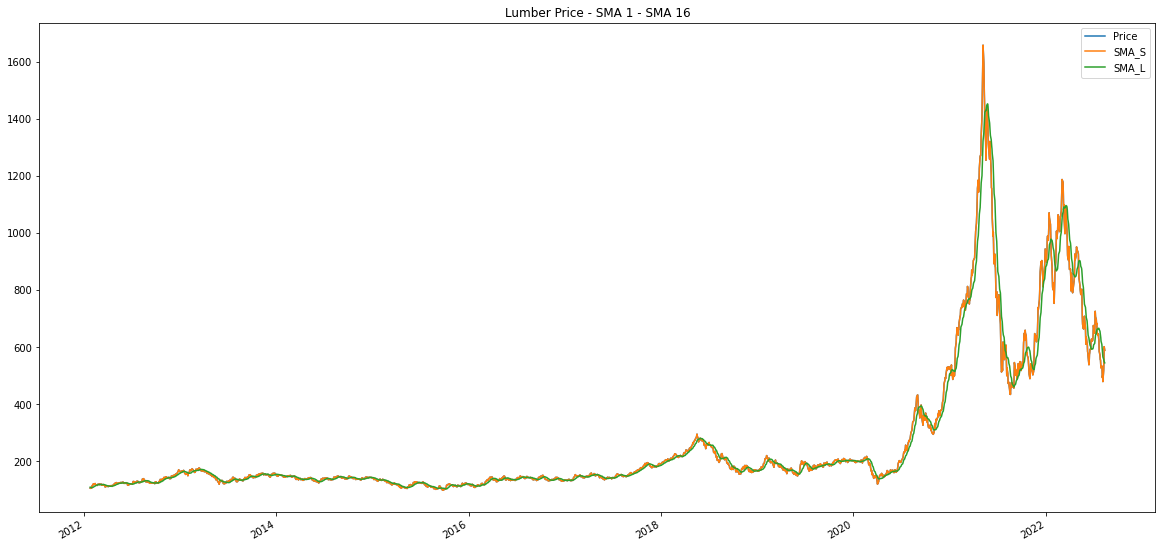

In [309]:
data.plot(figsize=(20,10), title = 'Lumber Price - SMA {} - SMA {}'.format(sma_s, sma_l));

In [310]:
data['position'] = np.where(data.SMA_S > data.SMA_L, 1, -1)
data

,Price,SMA_S,SMA_L,position
2012-01-25,105.595866,105.595866,109.021539,-1
2012-01-26,106.569100,106.569100,108.402208,-1
2012-01-27,105.065011,105.065011,107.929415,-1
2012-01-30,105.374677,105.374677,107.343263,-1
2012-01-31,109.798467,109.798467,107.158017,1
...,...,...,...,...
2022-08-08,519.299988,519.299988,557.631248,-1
2022-08-09,552.799988,552.799988,552.131248,1
2022-08-10,601.799988,601.799988,549.349998,1
2022-08-11,595.599976,595.599976,547.099998,1


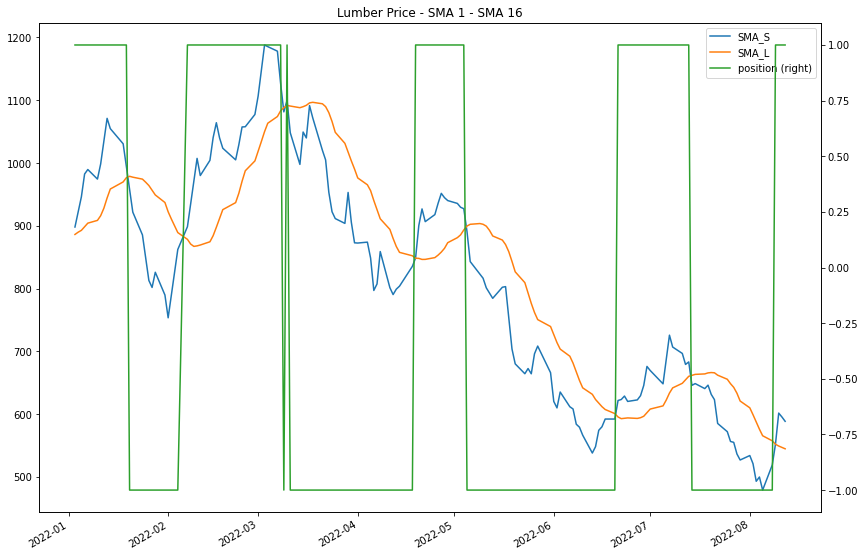

In [311]:
data.loc["2022",['SMA_S', 'SMA_L', 'position']].plot(figsize=(14,10), secondary_y=['position']
,title = 'Lumber Price - SMA {} - SMA {}'.format(sma_s, sma_l));

In [312]:
data['returns'] = np.log(data.Price.div(data.Price.shift(1)))
data['strategy'] = data.position.shift(1) * data.returns
data

,Price,SMA_S,SMA_L,position,returns,strategy
2012-01-25,105.595866,105.595866,109.021539,-1,NaN,NaN
2012-01-26,106.569100,106.569100,108.402208,-1,0.009174,-0.009174
2012-01-27,105.065011,105.065011,107.929415,-1,-0.014214,0.014214
2012-01-30,105.374677,105.374677,107.343263,-1,0.002943,-0.002943
2012-01-31,109.798467,109.798467,107.158017,1,0.041124,-0.041124
...,...,...,...,...,...,...
2022-08-08,519.299988,519.299988,557.631248,-1,0.080364,-0.080364
2022-08-09,552.799988,552.799988,552.131248,1,0.062515,-0.062515
2022-08-10,601.799988,601.799988,549.349998,1,0.084929,0.084929
2022-08-11,595.599976,595.599976,547.099998,1,-0.010356,-0.010356


In [313]:
data[['returns','strategy']].sum() # absolute performance of buy and hold and strategy

returns     1.718298
strategy    7.257428
dtype: float64

In [314]:
data[['returns','strategy']].sum().apply(np.exp) # absolute performance of buy and hold and strategy

returns        5.575029
strategy    1418.603017
dtype: float64

In [315]:
data[['returns','strategy']].mean() * 252 # Annualized performance of buy and hold and strategy

returns     0.162909
strategy    0.688063
dtype: float64

In [316]:
data[['returns','strategy']].std() * np.sqrt(252) # Annualized volatility of buy and hold and strategy

returns     0.348775
strategy    0.346222
dtype: float64

In [317]:
data['creturns'] = data.returns.cumsum().apply(np.exp) # Shows $1 investment at start
data['cstrategy'] = data.strategy.cumsum().apply(np.exp) # Shows $1 investment at start
data.dropna(inplace=True)
data

,Price,SMA_S,SMA_L,position,returns,strategy,creturns,cstrategy
2012-01-26,106.569100,106.569100,108.402208,-1,0.009174,-0.009174,1.009217,0.990868
2012-01-27,105.065011,105.065011,107.929415,-1,-0.014214,0.014214,0.994973,1.005053
2012-01-30,105.374677,105.374677,107.343263,-1,0.002943,-0.002943,0.997905,1.002099
2012-01-31,109.798467,109.798467,107.158017,1,0.041124,-0.041124,1.039799,0.961724
2012-02-01,112.364265,112.364265,107.312850,1,0.023099,0.023099,1.064097,0.984198
...,...,...,...,...,...,...,...,...
2022-08-08,519.299988,519.299988,557.631248,-1,0.080364,-0.080364,4.917806,1418.027233
2022-08-09,552.799988,552.799988,552.131248,1,0.062515,-0.062515,5.235053,1332.093960
2022-08-10,601.799988,601.799988,549.349998,1,0.084929,0.084929,5.699087,1450.170308
2022-08-11,595.599976,595.599976,547.099998,1,-0.010356,-0.010356,5.640372,1435.230006


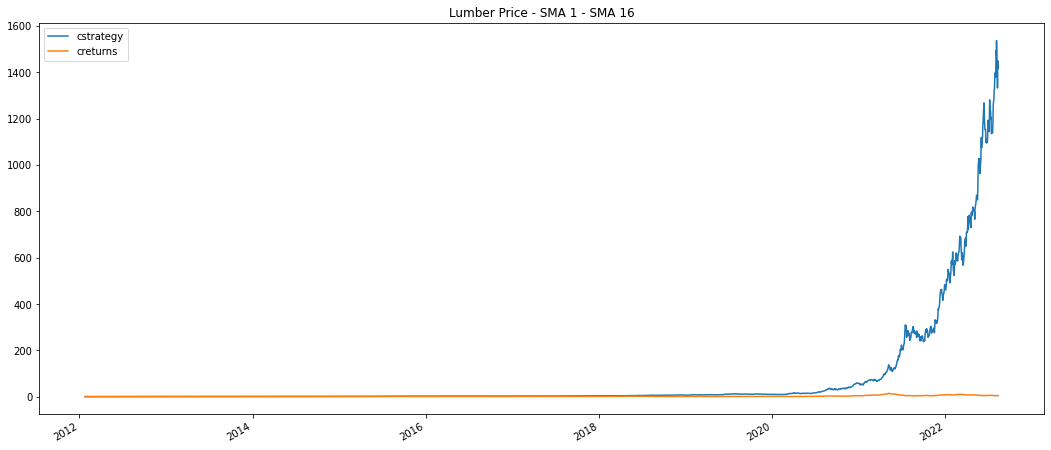

In [318]:
data[['cstrategy','creturns']].plot(figsize=(18,8), title = 'Lumber Price - SMA {} - SMA {}'.format(sma_s, sma_l));

In [319]:
outperf = data.cstrategy.iloc[-1] - data.creturns.iloc[-1]
outperf

1413.027987985749

### Finding the Optimal SMA Strategy

In [325]:
data = Lumber_OHLCVI.loc["2012":"2022"].dropna().copy()
data = data.Close.to_frame()
data.columns = ['Price']
data.sort_index(ascending=True, inplace=True)
data.head(2)

,Price
2012-01-03,116.478390
2012-01-04,112.629692


In [327]:
def run_strategy(SMA):
    df = data.copy()
    df['returns'] = np.log(df.Price.div(df.Price.shift(1)))
    df['SMA_S'] = df.Price.rolling(int(SMA[0])).mean()
    df['SMA_L'] = df.Price.rolling(int(SMA[1])).mean()
    df.dropna(inplace=True)

    df['position'] = np.where(df.SMA_S > df.SMA_L, 1, -1)
    df['strategy'] = df.position.shift(1) * df.returns
    df.dropna(inplace=True)

    return -df[['returns','strategy']].sum().apply(np.exp)[-1] # Maximize absolute performance of the strategy - since brute force minimizes so need negative


In [328]:
run_strategy((1,16))

-1418.603016945108

In [329]:
data

,Price
2012-01-03,116.478390
2012-01-04,112.629692
2012-01-05,114.753111
2012-01-06,112.762406
2012-01-09,109.886942
...,...
2022-08-08,519.299988
2022-08-09,552.799988
2022-08-10,601.799988
2022-08-11,595.599976


In [300]:
run_strategy((3,20))

-50.09224600001875

In [301]:
from scipy.optimize import brute

In [306]:
brute(run_strategy, ((1,50,1),(10,252,1)))  # first tuple is ranges for first SMA(start,stop and step)

array([ 1., 16.])

In [307]:
-run_strategy((1,16))

1418.603016945108